In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Ob_set is the Obesity set of date. It has the obesity rates from 2004 - 2012 per county
#Lets load in the data toutilize it further
#"number yyyy" is the percentage of obese idividuals based on the surverys done each year for the entire county
Obset = pd.read_excel("OB_PREV_ALL_STATES.xlsx", "obesity")
#Remove all the extra data in the Obesity list to leave just the numbers and % obese per county
for col in Obset.columns[3:]:
    if 'number' not in col and 'percent' not in col or 'age' in col:
        del Obset[col]

for col in Obset.columns[3:]:
    if '2009' not in col and '2012' not in col and '2010' not in col:
        del Obset[col]
        
#delete any NaN values for a better data set
Obset = Obset.dropna(how='any')

#Sort the set by FIPS nuber
Obset = Obset.sort(columns='FIPS Codes', axis=0)

In [3]:
#Food Access Data
FoodAccess = pd.read_excel("FoodSecAllup.xls", 'ACCESS')
#Food Security
Restaurants = pd.read_excel("FoodSecAllup.xls", 'RESTAURANTS')
#Food Stores Density
Stores = pd.read_excel("FoodSecAllup.xls", 'STORES')
#Farmers Market Data
FarmMkt = pd.read_csv("Farmers_market_Dir.csv")
#Food Assistance Data
Assistance = pd.read_excel("FoodSecAllup.xls", "ASSISTANCE")
#Food Inseciruty Data
Insecurity = pd.read_excel("FoodSecAllup.xls", "INSECURITY")
#Food Local Data
Local = pd.read_excel("FoodSecAllup.xls", "LOCAL")
#Food Prices and Taxes
FPrices = pd.read_excel("FoodSecAllup.xls", "PRICES_TAXES")
#Socioeconomic factors 
SociEcon = pd.read_excel("FoodSecAllup.xls", "SOCIOECONOMIC")

#### Famers Markets
This code finds how many farmers markets there are per county and then merges them to the Obesity data set on a County/State key that is necessary as the Farmers Markets data does not have the FIPS code which would designate which county the market is in.

In [4]:
#Drop (remove) the columns in the farmers market data set that we dont need
#remove all coumns but 9 & 10
FarmMkt = FarmMkt.drop(FarmMkt.columns[1:8], axis=1)#,inplace=True)
FarmMkt = FarmMkt.drop(FarmMkt.columns[4:], axis=1)
FarmMkt = FarmMkt.dropna(subset=['County'], how='all') #drop all rows that have any NaN values

#make a new column in FarmMkt and Obset to be a key to match the county/state pair
Obset['CSKey'] = Obset[['County','State']].sum(axis=1)
FarmMkt['CSKey'] = FarmMkt[['County','State']].sum(axis=1)

#New frame for the group by for the farmers market data
NewFrame = FarmMkt.groupby('CSKey').count()
NewFrame = NewFrame.drop(NewFrame.columns[1:], axis=1)
NewFrame.columns = ['FarmersMkts Per County']
#then merge it with the OBesity set to have the Fearmers market counts
#Obset['FarmersMkts Per County'] = Obset.merge(NewFrame, on=NewFrame.index, how='left')
Obset = pd.merge(Obset, NewFrame, how='left', left_on='CSKey',left_index=False, right_index=True, sort=True, copy=True)
#then drop the Key from the Obset data as no longer needed
Obset = Obset.drop(Obset.columns[Obset.columns.get_loc('CSKey')], axis=1)
#Change all the Nan values in the Famers count to 0
Obset['FarmersMkts Per County'] = Obset['FarmersMkts Per County'].fillna(int(0))
#Change all the Farmers market vals to ints
Obset['FarmersMkts Per County'] = Obset['FarmersMkts Per County'].astype(int)

#### Low Access to Grocery Stores
This code combines the Grocery store access data with the obesity set. 

3 Data Sets: 
1. Population's with low access to grocery stores
2. Population with Low income access to grocery stores
3. Population with no car and low income access to grocery stores

In [5]:
FoodAccess.head()

,FIPS,State,County,LACCESS_POP10,PCT_LACCESS_POP10,LACCESS_LOWI10,PCT_LACCESS_LOWI10,LACCESS_CHILD10,PCT_LACCESS_CHILD10,LACCESS_SENIORS10,PCT_LACCESS_SENIORS10,LACCESS_HHNV10,PCT_LACCESS_HHNV10
0,1001,Alabama,Autauga,18428.439685,33.769657,5344.427472,9.793530,4822.500269,8.837112,2388.233228,4.376378,664.216487,3.284786
1,1003,Alabama,Baldwin,35210.814078,19.318473,9952.144027,5.460261,7916.131932,4.343199,6404.008603,3.513570,1571.779915,2.147827
2,1005,Alabama,Barbour,5722.305602,20.840972,3135.676086,11.420316,940.419327,3.425062,770.214550,2.805166,406.142372,4.135869
3,1007,Alabama,Bibb,1044.867327,4.559753,491.449066,2.144661,249.204753,1.087518,150.553323,0.657008,275.060875,3.458580
4,1009,Alabama,Blount,1548.175559,2.700840,609.027708,1.062468,384.911607,0.671490,195.049051,0.340269,705.466783,3.269380


In [6]:
#Remove the FoodAcces columns we wont use:
for col in FoodAccess.columns[3:]:
    if 'PCT' not in col:
        del FoodAccess[col]

FoodAccess = FoodAccess.drop('PCT_LACCESS_CHILD10', axis=1)
FoodAccess = FoodAccess.drop('PCT_LACCESS_SENIORS10', axis=1)

In [7]:
#Merge the Access data to the Obset
Obset = pd.merge(Obset, FoodAccess.ix[:,3:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Grocery Stores and SuperCenters

4 Data Sets: 
1. Grocery Stores per 1000 people
2. Supercenters per 1000 people
3. Convenience Stores per 1000 people
4. SNAP accepting Stores per 1000 people

In [8]:
Stores.head()

,FIPS,State,County,GROC07,GROC12,PCH_GROC_07_12,GROCPTH07,GROCPTH12,PCH_GROCPTH_07_12,SUPERC07,...,PCH_SNAPS_08_12,SNAPSPTH08,SNAPSPTH12,PCH_SNAPSPTH_08_12,WICS08,WICS12,PCH_WICS_08_12,WICSPTH08,WICSPTH12,PCH_WICSPTH_08_12
0,1001,Alabama,Autauga,4,4,0.000000,0.080266,0.072054,-10.231653,1,...,17.232376,0.633846,0.674004,6.335682,6,5,-16.66667,0.119156,0.090067,-24.412460
1,1003,Alabama,Baldwin,23,26,13.043478,0.133090,0.136275,2.393253,3,...,68.870804,0.464876,0.725055,55.967619,25,27,8.00000,0.141875,0.141517,-0.252126
2,1005,Alabama,Barbour,6,5,-16.666667,0.201776,0.183817,-8.900408,0,...,63.921569,0.712227,1.280590,79.800887,6,7,16.66667,0.201099,0.257344,27.968330
3,1007,Alabama,Bibb,7,5,-28.571429,0.325809,0.221268,-32.086434,0,...,62.500000,0.463199,0.719122,55.251250,6,5,-16.66667,0.277919,0.221268,-20.383970
4,1009,Alabama,Blount,6,8,33.333333,0.105511,0.138346,31.119796,1,...,77.431907,0.370569,0.657144,77.333719,10,6,-40.00000,0.173028,0.103760,-40.033200


In [9]:
#Remove the FoodAcces columns we wont use:
for col in Stores.columns[3:]:
    if 'PTH12' not in col:
        del Stores[col]

Stores = Stores.drop('SPECSPTH12', axis=1)
Stores = Stores.drop('WICSPTH12', axis=1)

In [10]:
#Merge Restaurants
Obset = pd.merge(Obset, Stores.ix[:,3:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Restaurants
This code combines the Restaurant data with the obesity set. I will use the expenditure change from 02-07 to estimate the amount for 2012. 

4 Data Sets: 
1. Fast Food restaurants per 1000 people (2012)
2. Restaurants per 1000 people (2012)
3. Fast Food Restaurant Expenditures per capita (2012 estimate)
4. Restaurant Expenditures per capita (2012 estimate)

Estiamte Expenditures per capita: (2007/2002)*2007

In [11]:
Restaurants.head()

,FIPS,State,County,FFR07,FFR12,PCH_FFR_07_12,FFRPTH07,FFRPTH12,PCH_FFRPTH_07_12,FSR07,FSR12,PCH_FSR_07_12,FSRPTH07,FSRPTH12,PCH_FSRPTH_07_12,PC_FFRSALES02,PC_FFRSALES07,PC_FSRSALES02,PC_FSRSALES07
0,1001,Alabama,Autauga,32,34,6.250000,0.642132,0.612458,-4.621132,34,29,-14.705882,0.682265,0.522391,-23.432881,470,649.511367,349,484.381507
1,1003,Alabama,Baldwin,129,130,0.775194,0.746463,0.681377,-8.719193,184,211,14.673913,1.064722,1.105928,3.870079,470,649.511367,349,484.381507
2,1005,Alabama,Barbour,20,21,5.000000,0.672585,0.772030,14.785486,11,14,27.272727,0.369922,0.514687,39.133922,470,649.511367,349,484.381507
3,1007,Alabama,Bibb,8,6,-25.000000,0.372353,0.265522,-28.690755,8,4,-50.000000,0.372353,0.177015,-52.460504,470,649.511367,349,484.381507
4,1009,Alabama,Blount,27,22,-18.518519,0.474800,0.380452,-19.871236,14,13,-7.142857,0.246193,0.224812,-8.684428,470,649.511367,349,484.381507


In [12]:
#Remove the FoodAcces columns we wont use:
for col in Restaurants.columns[3:]:
    if 'PTH12' not in col and 'PC_F' not in col:
        del Restaurants[col]

In [13]:
#Find the change in expenditures and use this to estimate 2012
Restaurants['PC_FFRSALES12'] = ( Restaurants['PC_FFRSALES07'] / Restaurants['PC_FFRSALES02'] ) * Restaurants['PC_FFRSALES07']
Restaurants['PC_FSRSALES12'] = ( Restaurants['PC_FSRSALES07'] / Restaurants['PC_FSRSALES02'] ) * Restaurants['PC_FSRSALES07']

In [14]:
#Remove the now unneeded expenditure columns
Restaurants = Restaurants.drop('PC_FFRSALES02', axis=1)
Restaurants = Restaurants.drop('PC_FFRSALES07', axis=1)
Restaurants = Restaurants.drop('PC_FSRSALES02', axis=1)
Restaurants = Restaurants.drop('PC_FSRSALES07', axis=1)

In [15]:
#Merge Restaurants
Obset = pd.merge(Obset, Restaurants.ix[:,3:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Low Income Food Assistance

8 Data Sets: 
1. SNAP redemptions/SNAP-authorized stores, 2012
2. SNAP participants (% pop), 2009
3. SNAP benefits per capita, 2010
4. SNAP participants (% eligible pop), 2010*
5. National School Lunch Program participants (% pop), 2009
6. Students eligible for free lunch (%), 2010
7. Students eligible for reduced-price lunch (%), 2010
8. SchoolSchool Breakfast Program participants (% pop), 2009

In [16]:
Keep = ['FIPS','REDEMP_SNAPS12','PCT_SNAP09','PC_SNAPBEN10',
 'SNAP_PART_RATE10','PCT_NSLP09','PCT_FREE_LUNCH10','PCT_REDUCED_LUNCH10','PCT_SBP09']
Assistance2 = Assistance[Keep]

In [17]:
#Merge Assistance2
Obset = pd.merge(Obset, Assistance2.ix[:,1:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

In [18]:
Obset.head()

,State,FIPS Codes,County,number 2009,percent 2009,number 2010,percent 2010,number 2012,percent 2012,FarmersMkts Per County,...,PC_FFRSALES12,PC_FSRSALES12,REDEMP_SNAPS12,PCT_SNAP09,PC_SNAPBEN10,SNAP_PART_RATE10,PCT_NSLP09,PCT_FREE_LUNCH10,PCT_REDUCED_LUNCH10,PCT_SBP09
2311,South Carolina,45001,Abbeville,6066,32.6,6525,34.8,6425,34.2,1,...,1032.881405,1105.777696,231131.337600,15.187587,NaN,100,8.124539,53.490760,7.323751,3.628945
1108,Louisiana,22001,Acadia Parish,13691,32.7,13928,32.2,13957,31.9,0,...,769.455324,682.895059,318717.271879,7.778811,8.649992,69,12.647286,25.842386,7.963745,3.416376
2815,Virginia,51001,Accomack,9679,33.4,9056,35.5,9367,36.6,3,...,503.684250,813.832117,142285.647329,11.600135,NaN,98,8.823179,34.161158,7.253886,3.443290
546,Idaho,16001,Ada,64348,23.3,65831,23.5,71992,24.5,7,...,842.255078,724.786329,191042.948000,16.266542,17.268707,85,13.229950,48.005698,8.641975,5.534904
784,Iowa,19001,Adair,1726,30.6,1853,31.8,1767,31.0,1,...,875.445896,812.030461,233997.369150,8.813748,21.386731,81,10.997729,32.574937,8.522932,4.582090


#### Food Insecurity

2 Data Sets: 
1. Household food insecurity (%, three-year average), 2010-12
2. Household very low food security (%, three-year average), 2010-12

In [19]:
Keep = ['FIPS','FOODINSEC_10_12','VLFOODSEC_10_12']
Insecurity2 = Insecurity[Keep]

In [20]:
#Merge Assistance2
Obset = pd.merge(Obset, Insecurity2.ix[:,1:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

#### Local food Factors

2 Data Sets: 
1. Farmers' markets, 2013

In [21]:
Local.head()

,FIPS,State,County,DIRSALES_FARMS07,PCT_LOCLFARM07,PCT_LOCLSALE07,DIRSALES07,PC_DIRSALES07,FMRKT09,FMRKT13,...,BERRY_ACRESPTH07,SLHOUSE07,GHVEG_FARMS07,GHVEG_SQFT07,GHVEG_SQFTPTH07,FOODHUB12,CSA07,AGRITRSM_OPS07,AGRITRSM_RCT07,FARM_TO_SCHOOL
0,1001,Alabama,Autauga,25,6.0,0.6,100,2.01,2,1,...,NaN,0,0,0,0,0,2,7,228000,0
1,1003,Alabama,Baldwin,80,7.0,0.7,715,4.16,4,4,...,0.457136,1,0,0,0,0,13,18,124000,0
2,1005,Alabama,Barbour,18,2.9,0.0,11,0.37,2,3,...,NaN,0,0,0,0,0,1,27,163000,0
3,1007,Alabama,Bibb,12,5.7,NaN,46,2.14,1,1,...,0.279265,0,0,0,0,0,2,5,NaN,0
4,1009,Alabama,Blount,84,5.9,0.3,429,7.59,1,1,...,0.492386,0,2,NaN,NaN,0,7,10,293000,0


In [22]:
Keep = ['FIPS', 'FMRKT13']
Local2 = Local[Keep]

In [23]:
#Merge Assistance2
Obset2 = pd.merge(Obset, Local2.ix[:,1:], how='left', left_on='FIPS Codes',right_on ='FIPS',left_index=True, right_index=True, sort=True, copy=True)

In [24]:
Obset2['FDiff'] = Obset2['FarmersMkts Per County'] - Obset2['FMRKT13']

In [25]:
Obset2['FDiff'].describe()

count    3103.000000
mean       -0.220110
std         7.103923
min      -129.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max       112.000000
Name: FDiff, dtype: float64

In [26]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Multivariable Regression

Here I will use the sklearn linear_model to see if there is any relationship between the many variables that I have loaded into the Obset

Column Name| Description
-|-
FarmersMkts Per County| Farmers Markets Per County  
PCT_LACCESS_POP10| Percent of the popultion who have access to grocery stores  
PCT_LACCESS_LOWI10| Low Income Percent of the popultion who have access to grocery stores  
PCT_LACCESS_HHNV10| Low Income Percent of the popultion who have access to grocery stores without a car  
GROCPTH12| Grocery stores per 1000 people  
SUPERCPTH12| Supercenters per 1000 people  
CONVSPTH12| Convenience Stores per 1000 people  
SNAPSPTH12| SNAP-authorized stores per 1,000 people  
FFRPTH12| Fast-food restaurants per 1,000 people  
FSRPTH12| Full-service restaurants per 1,000 people  
PC_FFRSALES12| Expenditures per capita, fast food  
PC_FSRSALES12| Expenditures per capita, full service restaurant  
REDEMP_SNAPS12| SNAP redemptions/SNAP-authorized stores  
PCT_SNAP09| SNAP participants (% pop)  
PC_SNAPBEN10| SNAP benefits per capita  
SNAP_PART_RATE10| SNAP participants (% eligible pop)  
PCT_NSLP09| National School Lunch Program participants (% pop)  
PCT_FREE_LUNCH10| Students eligible for free lunch (%)  
PCT_REDUCED_LUNCH10| Students eligible for reduced-price lunch (%)  
PCT_SBP09| School Breakfast Program participants (% pop)  
FOODINSEC_10_12| Household food insecurity (%, three-year average)  
VLFOODSEC_10_12| Household very low food security (%, three-year average)


In [27]:
from sklearn import linear_model
from sklearn import cross_validation

ObsetRun = Obset.dropna(how='any')

In [28]:
Obset3 = Obset.dropna(how='any')

#Load Train and Test datasets
#Identify feature and response variable(s) and values must be numeric and numpy arrays
ColNames = ['FarmersMkts Per County', 'PCT_LACCESS_POP10','PCT_LACCESS_LOWI10', 'PCT_LACCESS_HHNV10', 'GROCPTH12',
       'SUPERCPTH12', 'CONVSPTH12', 'SNAPSPTH12', 'FFRPTH12','FSRPTH12', 'PC_FFRSALES12', 'PC_FSRSALES12', 'REDEMP_SNAPS12',
       'PCT_SNAP09', 'PC_SNAPBEN10', 'SNAP_PART_RATE10', 'PCT_NSLP09','PCT_FREE_LUNCH10', 'PCT_REDUCED_LUNCH10', 'PCT_SBP09',
       'FOODINSEC_10_12', 'VLFOODSEC_10_12']

x_train, x_test, y_train, y_test = cross_validation.train_test_split(Obset3[ColNames], Obset3['percent 2012'],train_size=.9)

# Create linear regression object
linear = linear_model.LinearRegression()

#Cross Validation for multiple results
Lin_vals = cross_validation.cross_val_score(linear, x_train, y_train, cv=10)

# Train the model using the training sets and check score
linear.fit(x_train, y_train)
linear.score(x_train, y_train)

#Equation coefficient and Intercept
#print 'Coefficient: \n', linear.coef_
#print
#print 'Intercept: %.4f' % linear.intercept_
#print 
#print 'Variance score: %.4f' % linear.score(x_test, y_test)
#print 
print 'Linear Val Scores: \n', Lin_vals
print
print 'Mean Linear Val Score: \n', np.mean(Lin_vals)

Linear Val Scores: 
[ 0.20770397  0.19656174  0.26683659  0.16080879  0.29275297  0.24615867
  0.2219972   0.16486412  0.20460455  0.14678354]

Mean Linear Val Score: 
0.210907213594


##### Conclusion: Poor fit
The coefficients of the line vary too much to get a meaningful model.
###### Next Step: Group the Variables by type and make multiple multivariable linear regression lines:

In [29]:
ColNames = ['FarmersMkts Per County', 'PCT_LACCESS_POP10','PCT_LACCESS_LOWI10', 'PCT_LACCESS_HHNV10', 'GROCPTH12',
       'SUPERCPTH12', 'CONVSPTH12', 'SNAPSPTH12', 'FFRPTH12','FSRPTH12', 'PC_FFRSALES12', 'PC_FSRSALES12', 'REDEMP_SNAPS12',
       'PCT_SNAP09', 'PC_SNAPBEN10', 'SNAP_PART_RATE10', 'PCT_NSLP09','PCT_FREE_LUNCH10', 'PCT_REDUCED_LUNCH10', 'PCT_SBP09',
       'FOODINSEC_10_12', 'VLFOODSEC_10_12']

FoodAccess = ['FarmersMkts Per County', 'PCT_LACCESS_POP10','PCT_LACCESS_LOWI10', 'PCT_LACCESS_HHNV10', 'GROCPTH12',
              'SUPERCPTH12', 'CONVSPTH12','FFRPTH12','FSRPTH12']

SocioEcon = ['SNAPSPTH12','REDEMP_SNAPS12','PCT_SNAP09', 'PC_SNAPBEN10', 'SNAP_PART_RATE10', 'PCT_NSLP09','PCT_FREE_LUNCH10', 
             'PCT_REDUCED_LUNCH10', 'PCT_SBP09','FOODINSEC_10_12', 'VLFOODSEC_10_12']

SNAP = ['SNAPSPTH12','REDEMP_SNAPS12','PCT_SNAP09', 'PC_SNAPBEN10', 'SNAP_PART_RATE10']

PopAct = ['PC_FFRSALES12', 'PC_FSRSALES12']

Look up:
Feature importance
Feature weight


## Classify the Obesity Rate to Apply Logisitic Regression

Since the Obesity rate has a large variance our modeling is not good at predicting it accurately so here I will categorize the Obesity rate into 2 classes: Acceptable and Unnaceptable. 

This categorization will be determined by the median value of the percentage of Obesity per county. If the county is below the median, it will be classified with a 0 and 1 otherwise. 

In [30]:
obmedian = np.median(Obset['percent 2012'])
print obmedian
#obmedian = 29.0 #this is the cut off that the government uses to distinguish between high and low obesity % rates

def medd(percent):
    if percent > obmedian:
        return 1
    else:
        return 0

In [31]:
Obset['median12'] = Obset['percent 2012'].apply(medd)

#### All 22 FDA Factors:
This is the Multivariable Linear Regression modelling for all 22 Food Factor Variables. 

In [32]:
ObsetRun = Obset.dropna(how='any')

X = ObsetRun[ColNames]
y = ObsetRun['median12']

x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y,train_size=.9)

X = x_train
y = y_train

# Create linear regression object
linear = linear_model.LinearRegression()

#Another model: bagging decision trees
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Another model: boosting decision trees
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Cross Validation for multiple results
Lin_vals = cross_validation.cross_val_score(linear, x_train, y_train, cv=10)
Bag_vals = cross_validation.cross_val_score(bagging, X.values, y.values, cv=10)
Boost_vals = cross_validation.cross_val_score(boosting, X.values, y.values,cv=10)

# Train the model using the training sets and check score
linear.fit(x_train, y_train)
linear.score(x_train, y_train)
bagging.fit(x_train, y_train)
bagging.score(x_train, y_train)
boosting.fit(x_train, y_train)
boosting.score(x_train, y_train)

#Equation coefficient and Intercept
#print 'Coefficient: \n', linear.coef_
#print
#print 'Intercept: %.4f' % linear.intercept_
#print 
#print 'Variance score: %.4f' % linear.score(x_test, y_test)
#print 
print 'Linear Val Scores: \n', Lin_vals
print 'Mean Linear Val Score: \n', np.mean(Lin_vals)
print 
print 'Bagging Val Scores: \n', Bag_vals
print 'Mean Bagging Val Score: \n', np.mean(Bag_vals)
print 
print 'Boosting Val Scores: \n', Boost_vals
print 'Mean Boost Val Score: \n', np.mean(Boost_vals)

Linear Val Scores: 
[ 0.12539906  0.08805888  0.08495614  0.05877553  0.09871524  0.06831835
  0.08374511  0.10097243  0.10458729  0.05324529]
Mean Linear Val Score: 
0.0866773337926

Bagging Val Scores: 
[ 0.70995671  0.6969697   0.67965368  0.74025974  0.68558952  0.66812227
  0.66375546  0.6768559   0.66375546  0.68558952]
Mean Bagging Val Score: 
0.687050794911

Boosting Val Scores: 
[ 0.63203463  0.61038961  0.64069264  0.67965368  0.61135371  0.56331878
  0.6768559   0.59388646  0.62445415  0.65938865]
Mean Boost Val Score: 
0.629202820469


In [33]:
from sklearn.ensemble import RandomForestClassifier

## DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=None, min_samples_split=1,random_state=0)
scores = cross_validation.cross_val_score(dtree, X.values, y.values,10)
print "DecisionTreeClassifier Max None:", scores.mean()
dtree.fit(x_train, y_train)
cm = confusion_matrix(y_test, dtree.predict(x_test))
print cm

#Decision tree with 1/2 the max depth to prevent over fitting
dtree = DecisionTreeClassifier(max_depth=12, min_samples_split=1,random_state=0)
scores = cross_validation.cross_val_score(dtree, X.values, y.values)
print "DecisionTreeClassifier Max None:", scores.mean()
dtree.fit(x_train, y_train)
cm = confusion_matrix(y_test, dtree.predict(x_test))
print cm

## Bagged Decision Trees
scores = cross_validation.cross_val_score(bagging,X.values, y.values)
print "BaggedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, bagging.predict(x_test))
print cm

## Boosted Decision Trees
scores = cross_validation.cross_val_score(boosting, X.values, y.values)
print "BoostedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, boosting.predict(x_test))
print cm

## RandomForestClassifier 5
forest = RandomForestClassifier(n_estimators=500,
     max_features=5, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier 5:", scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

## RandomForestClassifier 7
forest = RandomForestClassifier(n_estimators=500,
     max_features=7, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier 7:", scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

## RandomForestClassifier Max
maxRF = len(FoodAccess)
forest = RandomForestClassifier(n_estimators=500,
     max_features=maxRF, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier %i:" % maxRF,scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

DecisionTreeClassifier: 0.610512833788
[[71 44]
 [58 83]]
BaggedTreeClassifier: 0.685820212256
[[ 77  38]
 [ 38 103]]
BoostedTreeClassifier: 0.614861617494
[[70 45]
 [61 80]]
RandomForestClassifier 5: 0.686674060225
[[79 36]
 [42 99]]
RandomForestClassifier 7: 0.701038934627
[[80 35]
 [43 98]]
RandomForestClassifier 9: 0.693210000521
[[ 79  36]
 [ 41 100]]


Feature ranking:
1. feature FarmersMkts Per County (0.0772687671094)
2. feature PCT_LACCESS_POP10 (0.057504554044)
3. feature PCT_LACCESS_LOWI10 (0.0574908228099)
4. feature PCT_LACCESS_HHNV10 (0.057012744438)
5. feature GROCPTH12 (0.056990068884)
6. feature SUPERCPTH12 (0.0545176616015)
7. feature CONVSPTH12 (0.0541393204549)
8. feature SNAPSPTH12 (0.0537021546909)
9. feature FFRPTH12 (0.0531241888875)
10. feature FSRPTH12 (0.0515552726398)
11. feature PC_FFRSALES12 (0.0502329972497)
12. feature PC_FSRSALES12 (0.049701279942)
13. feature REDEMP_SNAPS12 (0.0495676775848)
14. feature PCT_SNAP09 (0.0493010610171)
15. feature PC_SNAPBEN10 (0.0476187714876)
16. feature SNAP_PART_RATE10 (0.0340208848533)
17. feature PCT_NSLP09 (0.0334311132973)
18. feature PCT_FREE_LUNCH10 (0.0298105893107)
19. feature PCT_REDUCED_LUNCH10 (0.0253038586291)
20. feature PCT_SBP09 (0.0233502685305)
21. feature FOODINSEC_10_12 (0.0191974564683)
22. feature VLFOODSEC_10_12 (0.0151584860697)


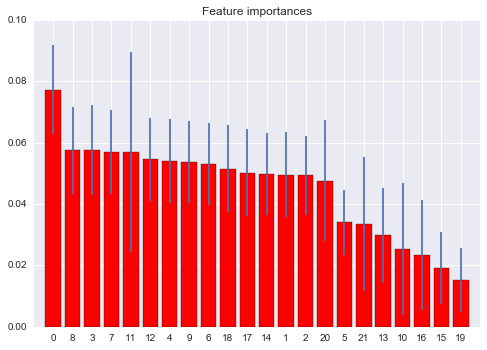

In [34]:
importances = forest.fit(X.values, y.values).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.values.shape[1]):
    print("{0}. feature {1} ({2})".format(f + 1, ColNames[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.values.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.values.shape[1]), indices)
plt.xlim([-1, X.values.shape[1]])
plt.show()

Cross validation  
confusion matrix  
weighted sum of the variables in the 1/0 graph

----

###### Food Access Regression Analysis

In [35]:
ObsetFA = Obset.dropna(how='any')

X = ObsetFA[FoodAccess]
y = ObsetFA['median12']

x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y,train_size=.9)

X = x_train
y = y_train

# Create linear regression object
linear = linear_model.LinearRegression()

#Another model: bagging decision trees
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Another model: boosting decision trees
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Cross Validation for multiple results
Lin_vals = cross_validation.cross_val_score(linear, x_train, y_train, cv=10)
Bag_vals = cross_validation.cross_val_score(bagging, X.values, y.values, cv=10)
Boost_vals = cross_validation.cross_val_score(boosting, X.values, y.values,cv=10)

# Train the model using the training sets and check score
linear.fit(x_train, y_train)
linear.score(x_train, y_train)
bagging.fit(x_train, y_train)
bagging.score(x_train, y_train)
boosting.fit(x_train, y_train)
boosting.score(x_train, y_train)

#Equation coefficient and Intercept
#print 'Coefficient: \n', linear.coef_
#print
#print 'Intercept: %.4f' % linear.intercept_
#print 
#print 'Variance score: %.4f' % linear.score(x_test, y_test)
#print 
print 'Linear Val Scores: \n', Lin_vals
print 'Mean Linear Val Score: \n', np.mean(Lin_vals)
print 
print 'Bagging Val Scores: \n', Bag_vals
print 'Mean Bagging Val Score: \n', np.mean(Bag_vals)
print 
print 'Boosting Val Scores: \n', Boost_vals
print 'Mean Boost Val Score: \n', np.mean(Boost_vals)

Linear Val Scores: 
[ 0.06595371  0.05469615  0.01277063  0.04616428  0.07376093  0.05144456
  0.03775776  0.02787214  0.06567975  0.08167758]
Mean Linear Val Score: 
0.0517777500073

Bagging Val Scores: 
[ 0.59565217  0.60869565  0.60434783  0.56521739  0.68695652  0.60869565
  0.56521739  0.53913043  0.56331878  0.59825328]
Mean Bagging Val Score: 
0.593548509588

Boosting Val Scores: 
[ 0.53043478  0.6         0.53913043  0.56521739  0.5826087   0.55217391
  0.57826087  0.56086957  0.48034934  0.52838428]
Mean Boost Val Score: 
0.551742927663


In [36]:
from sklearn.ensemble import RandomForestClassifier

## DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=None, min_samples_split=1,random_state=0)
scores = cross_validation.cross_val_score(dtree, X.values, y.values)
print "DecisionTreeClassifier:", scores.mean()
dtree.fit(x_train, y_train)
cm = confusion_matrix(y_test, dtree.predict(x_test))
print cm

## Bagged Decision Trees
scores = cross_validation.cross_val_score(bagging,X.values, y.values)
print "BaggedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, bagging.predict(x_test))
print cm

## Boosted Decision Trees
scores = cross_validation.cross_val_score(boosting, X.values, y.values)
print "BoostedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, boosting.predict(x_test))
print cm

## RandomForestClassifier 5
forest = RandomForestClassifier(n_estimators=500,
     max_features=5, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier 5:", scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

## RandomForestClassifier 7
forest = RandomForestClassifier(n_estimators=500,
     max_features=7, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier 7:", scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

## RandomForestClassifier Max
maxRF = len(FoodAccess)
forest = RandomForestClassifier(n_estimators=500,
     max_features=maxRF, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier %i:" % maxRF,scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

DecisionTreeClassifier: 0.537834061286
[[67 54]
 [61 74]]
BaggedTreeClassifier: 0.583534523593
[[71 50]
 [49 86]]
BoostedTreeClassifier: 0.546535583864
[[68 53]
 [53 82]]
RandomForestClassifier 5: 0.581360420609
[[66 55]
 [46 89]]
RandomForestClassifier 7: 0.580049826939
[[71 50]
 [49 86]]
RandomForestClassifier 9: 0.576570814214
[[68 53]
 [48 87]]


Feature ranking:
1. feature FarmersMkts Per County (0.136839375828)
2. feature PCT_LACCESS_POP10 (0.12826563214)
3. feature PCT_LACCESS_LOWI10 (0.126976661245)
4. feature PCT_LACCESS_HHNV10 (0.118005911712)
5. feature GROCPTH12 (0.117908558603)
6. feature SUPERCPTH12 (0.104079546203)
7. feature CONVSPTH12 (0.101214489123)
8. feature SNAPSPTH12 (0.0981801383257)
9. feature FFRPTH12 (0.0685296868202)


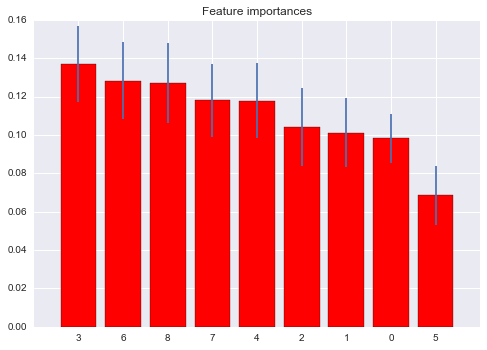

In [37]:
importances = forest.fit(X.values, y.values).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.values.shape[1]):
    print("{0}. feature {1} ({2})".format(f + 1, ColNames[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.values.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.values.shape[1]), indices)
plt.xlim([-1, X.values.shape[1]])
plt.show()

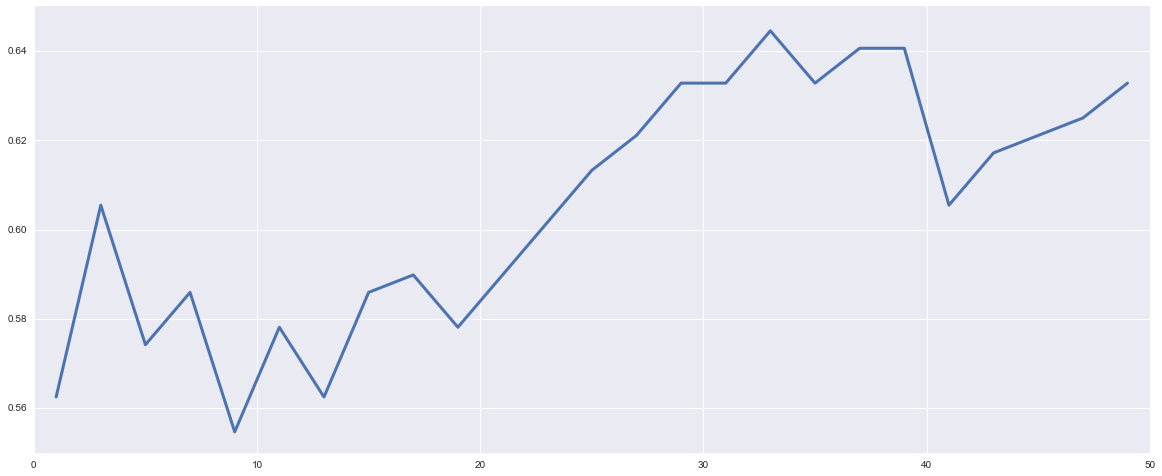

In [44]:
n_neighbors = range(1,51,2)

scores = []
for n in n_neighbors:
    model = KNN(n)
    model.fit(x_train, y_train)
    scores.append(model.score(x_test, y_test))
    
plt.figure(figsize=(20,8))
plt.plot(n_neighbors, scores, linewidth=3.0)
plt.show()

In [45]:
from sklearn import cross_validation

K_hold = {}
count_n = 0
count_f = 0
for n in n_neighbors:
    model = KNN(n)
    count_n += 1
    n_scores = cross_validation.cross_val_score(model, x_train, y_train, cv=10) #, scoring='mean_squared_error')
    K_hold[count_n] = "Accuracy: %0.2f (+/- %0.2f)" % (n_scores.mean(), n_scores.std() * 2)
    count_f += 1

In [47]:
print("Accuracy: %0.2f (+/- %0.2f)" % (n_scores.mean(), n_scores.std() * 2))
print K_hold

Accuracy: 0.59 (+/- 0.08)
{1: 'Accuracy: 0.52 (+/- 0.07)', 2: 'Accuracy: 0.55 (+/- 0.08)', 3: 'Accuracy: 0.56 (+/- 0.07)', 4: 'Accuracy: 0.57 (+/- 0.05)', 5: 'Accuracy: 0.56 (+/- 0.04)', 6: 'Accuracy: 0.57 (+/- 0.05)', 7: 'Accuracy: 0.58 (+/- 0.05)', 8: 'Accuracy: 0.58 (+/- 0.05)', 9: 'Accuracy: 0.58 (+/- 0.06)', 10: 'Accuracy: 0.58 (+/- 0.06)', 11: 'Accuracy: 0.58 (+/- 0.04)', 12: 'Accuracy: 0.58 (+/- 0.03)', 13: 'Accuracy: 0.58 (+/- 0.05)', 14: 'Accuracy: 0.58 (+/- 0.05)', 15: 'Accuracy: 0.58 (+/- 0.05)', 16: 'Accuracy: 0.59 (+/- 0.06)', 17: 'Accuracy: 0.58 (+/- 0.06)', 18: 'Accuracy: 0.58 (+/- 0.06)', 19: 'Accuracy: 0.59 (+/- 0.05)', 20: 'Accuracy: 0.59 (+/- 0.06)', 21: 'Accuracy: 0.59 (+/- 0.06)', 22: 'Accuracy: 0.59 (+/- 0.07)', 23: 'Accuracy: 0.59 (+/- 0.07)', 24: 'Accuracy: 0.59 (+/- 0.08)', 25: 'Accuracy: 0.59 (+/- 0.08)'}


In [48]:
scores=[]
for n in n_neighbors:
    model = KNN(n)
    model.fit(X,y)
    scores.append(cross_validation.cross_val_score(model, X, y, cv=10)) #, scoring='mean_squared_error')
print scores

[array([ 0.50869565,  0.56521739,  0.53913043,  0.57391304,  0.50434783,
        0.46956522,  0.52173913,  0.54782609,  0.47161572,  0.49781659]), array([ 0.52173913,  0.62608696,  0.58695652,  0.5826087 ,  0.56521739,
        0.50869565,  0.50434783,  0.53478261,  0.50218341,  0.52401747]), array([ 0.54347826,  0.60869565,  0.6173913 ,  0.59130435,  0.56956522,
        0.5173913 ,  0.52173913,  0.5173913 ,  0.55458515,  0.55458515]), array([ 0.53913043,  0.57826087,  0.6       ,  0.54782609,  0.58695652,
        0.57391304,  0.55217391,  0.52608696,  0.55458515,  0.60262009]), array([ 0.53913043,  0.57391304,  0.54782609,  0.57391304,  0.57826087,
        0.56521739,  0.54347826,  0.52608696,  0.54148472,  0.60262009]), array([ 0.53913043,  0.56521739,  0.57391304,  0.60434783,  0.56956522,
        0.57826087,  0.54782609,  0.54347826,  0.54148472,  0.62445415]), array([ 0.56086957,  0.5826087 ,  0.6       ,  0.60869565,  0.57391304,
        0.59130435,  0.55652174,  0.55217391,  0.54

In [49]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import metrics
model = KNN(13, weights='uniform')
model.fit(x_train, y_train)
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
print cm
cross_validation.cross_val_score(model, X, y, cv=10)

Boost_vals = cross_validation.cross_val_score(boosting, X.values, y.values,cv=10)

[[60 61]
 [51 84]]


###### SocioEconomic Regression Analysis

In [ ]:
ObsetSE = Obset.dropna(how='any')

X = ObsetSE[SocioEcon]
y = ObsetSE['median12']

x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y,train_size=.9)

X = x_train
y = y_train

# Create linear regression object
linear = linear_model.LinearRegression()

#Another model: bagging decision trees
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Another model: boosting decision trees
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Cross Validation for multiple results
Lin_vals = cross_validation.cross_val_score(linear, x_train, y_train, cv=10)
Bag_vals = cross_validation.cross_val_score(bagging, X.values, y.values, cv=10)
Boost_vals = cross_validation.cross_val_score(boosting, X.values, y.values,cv=10)

# Train the model using the training sets and check score
linear.fit(x_train, y_train)
linear.score(x_train, y_train)
bagging.fit(x_train, y_train)
bagging.score(x_train, y_train)
boosting.fit(x_train, y_train)
boosting.score(x_train, y_train)

#Equation coefficient and Intercept
#print 'Coefficient: \n', linear.coef_
#print
#print 'Intercept: %.4f' % linear.intercept_
#print 
#print 'Variance score: %.4f' % linear.score(x_test, y_test)
#print 
print 'Linear Val Scores: \n', Lin_vals
print 'Mean Linear Val Score: \n', np.mean(Lin_vals)
print 
print 'Bagging Val Scores: \n', Bag_vals
print 'Mean Bagging Val Score: \n', np.mean(Bag_vals)
print 
print 'Boosting Val Scores: \n', Boost_vals
print 'Mean Boost Val Score: \n', np.mean(Boost_vals)

In [ ]:
cm = confusion_matrix(y_test, bagging.predict(x_test))
print cm
plot_confusion_matrix(cm)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=None, min_samples_split=1,random_state=0)
scores = cross_validation.cross_val_score(dtree, X.values, y.values)
print "DecisionTreeClassifier:", scores.mean()
dtree.fit(x_train, y_train)
cm = confusion_matrix(y_test, dtree.predict(x_test))
print cm

## Bagged Decision Trees
scores = cross_validation.cross_val_score(bagging,X.values, y.values)
print "BaggedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, bagging.predict(x_test))
print cm

## Boosted Decision Trees
scores = cross_validation.cross_val_score(boosting, X.values, y.values)
print "BoostedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, boosting.predict(x_test))
print cm

## RandomForestClassifier 5
forest = RandomForestClassifier(n_estimators=500,
     max_features=5, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier 5:", scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

## RandomForestClassifier 7
forest = RandomForestClassifier(n_estimators=500,
     max_features=7, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier 7:", scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

## RandomForestClassifier Max
maxRF = len(FoodAccess)
forest = RandomForestClassifier(n_estimators=500,
     max_features=maxRF, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier %i:" % maxRF,scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

In [ ]:
importances = forest.fit(X.values, y.values).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.values.shape[1]):
    print("{0}. feature {1} ({2})".format(f + 1, ColNames[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.values.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.values.shape[1]), indices)
plt.xlim([-1, X.values.shape[1]])
plt.show()

In [ ]:
list(X.columns)

###### Population Actions Regression Analysis

In [ ]:
ObsetPA = Obset.dropna(how='any')

X = ObsetPA[PopAct]
y = ObsetPA['median12']

x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y,train_size=.9)

X = x_train
y = y_train

# Create linear regression object
linear = linear_model.LinearRegression()

#Another model: bagging decision trees
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Another model: boosting decision trees
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Cross Validation for multiple results
Lin_vals = cross_validation.cross_val_score(linear, x_train, y_train, cv=10)
Bag_vals = cross_validation.cross_val_score(bagging, X.values, y.values, cv=10)
Boost_vals = cross_validation.cross_val_score(boosting, X.values, y.values,cv=10)

# Train the model using the training sets and check score
linear.fit(x_train, y_train)
linear.score(x_train, y_train)
bagging.fit(x_train, y_train)
bagging.score(x_train, y_train)
boosting.fit(x_train, y_train)
boosting.score(x_train, y_train)

#Equation coefficient and Intercept
#print 'Coefficient: \n', linear.coef_
#print
#print 'Intercept: %.4f' % linear.intercept_
#print 
#print 'Variance score: %.4f' % linear.score(x_test, y_test)
#print 
print 'Linear Val Scores: \n', Lin_vals
print 'Mean Linear Val Score: \n', np.mean(Lin_vals)
print 
print 'Bagging Val Scores: \n', Bag_vals
print 'Mean Bagging Val Score: \n', np.mean(Bag_vals)
print 
print 'Boosting Val Scores: \n', Boost_vals
print 'Mean Boost Val Score: \n', np.mean(Boost_vals)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=None, min_samples_split=1,random_state=0)
scores = cross_validation.cross_val_score(dtree, X.values, y.values)
print "DecisionTreeClassifier:", scores.mean()
dtree.fit(x_train, y_train)
cm = confusion_matrix(y_test, dtree.predict(x_test))
print cm

## Bagged Decision Trees
scores = cross_validation.cross_val_score(bagging,X.values, y.values)
print "BaggedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, bagging.predict(x_test))
print cm

## Boosted Decision Trees
scores = cross_validation.cross_val_score(boosting, X.values, y.values)
print "BoostedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, boosting.predict(x_test))
print cm

## RandomForestClassifier Max
maxRF = len(FoodAccess)
forest = RandomForestClassifier(n_estimators=500,
     max_features=maxRF, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier %i:" % maxRF,scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

In [ ]:
importances = forest.fit(X.values, y.values).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.values.shape[1]):
    print("{0}. feature {1} ({2})".format(f + 1, ColNames[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.values.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.values.shape[1]), indices)
plt.xlim([-1, X.values.shape[1]])
plt.show()

###### SNAP Regression Analysis

In [ ]:
ObsetSNAP = Obset.dropna(how='any')

X = ObsetSNAP[SNAP]
y = ObsetSNAP['median12']

x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y,train_size=.9)

X = x_train
y = y_train

# Create linear regression object
linear = linear_model.LinearRegression()

#Another model: bagging decision trees
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Another model: boosting decision trees
boosting = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=250)

#Cross Validation for multiple results
Lin_vals = cross_validation.cross_val_score(linear, x_train, y_train, cv=10)
Bag_vals = cross_validation.cross_val_score(bagging, X.values, y.values, cv=10)
Boost_vals = cross_validation.cross_val_score(boosting, X.values, y.values,cv=10)

# Train the model using the training sets and check score
linear.fit(x_train, y_train)
linear.score(x_train, y_train)
bagging.fit(x_train, y_train)
bagging.score(x_train, y_train)
boosting.fit(x_train, y_train)
boosting.score(x_train, y_train)

#Equation coefficient and Intercept
#print 'Coefficient: \n', linear.coef_
#print
#print 'Intercept: %.4f' % linear.intercept_
#print 
#print 'Variance score: %.4f' % linear.score(x_test, y_test)
#print 
print 'Linear Val Scores: \n', Lin_vals
print 'Mean Linear Val Score: \n', np.mean(Lin_vals)
print 
print 'Bagging Val Scores: \n', Bag_vals
print 'Mean Bagging Val Score: \n', np.mean(Bag_vals)
print 
print 'Boosting Val Scores: \n', Boost_vals
print 'Mean Boost Val Score: \n', np.mean(Boost_vals)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=None, min_samples_split=1,random_state=0)
scores = cross_validation.cross_val_score(dtree, X.values, y.values)
print "DecisionTreeClassifier:", scores.mean()
dtree.fit(x_train, y_train)
cm = confusion_matrix(y_test, dtree.predict(x_test))
print cm

## Bagged Decision Trees
scores = cross_validation.cross_val_score(bagging,X.values, y.values)
print "BaggedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, bagging.predict(x_test))
print cm

## Boosted Decision Trees
scores = cross_validation.cross_val_score(boosting, X.values, y.values)
print "BoostedTreeClassifier:", scores.mean()
cm = confusion_matrix(y_test, boosting.predict(x_test))
print cm

## RandomForestClassifier Max
maxRF = len(FoodAccess)
forest = RandomForestClassifier(n_estimators=500,
     max_features=maxRF, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X.values, y.values)
print "RandomForestClassifier %i:" % maxRF,scores.mean()
forest.fit(x_train, y_train)
cm = confusion_matrix(y_test, forest.predict(x_test))
print cm

In [ ]:
importances = forest.fit(X.values, y.values).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.values.shape[1]):
    print("{0}. feature {1} ({2})".format(f + 1, ColNames[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.values.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.values.shape[1]), indices)
plt.xlim([-1, X.values.shape[1]])
plt.show()